Prefix,Genome,Region,GFF
<chr>,<chr>,<chr>,<chr>
AP85_Chr7D,~/reference/AP85/Sspon.HiC_chr_asm.fasta,Chr7D:18873565-18940673,~/reference/AP85/Sspon.v20190103.revised.gff3
ROC22_Chr2D,~/reference/ROC22/ROC22.V0917.geno.fasta,Chr2D:64948000-65018000,~/reference/ROC22/ROC22.V0917.geno.gff3
ROC22_Chr9F,~/reference/ROC22/ROC22.V0917.geno.fasta,Chr9F:54540000-54610000,~/reference/ROC22/ROC22.V0917.geno.gff3
LAp_Chr9B,~/reference/LA_purple/LAp_v20220608.genome.fasta,Chr09B:47515412-47585364,~/reference/LA_purple/LAp.v20220608.gff3
LAp_Chr9G,~/reference/LA_purple/LAp_v20220608.genome.fasta,Chr09G:45395872-45465824,~/reference/LA_purple/LAp.v20220608.gff3


[1] "echo -e 'Chr7D\t18873565\t18940673' | bedtools intersect -a - -b ~/reference/AP85/Sspon.v20190103.revised.gff3 -wo > AP85_Chr7D.gff3"
[1] "echo -e 'Chr2D\t64948000\t65018000' | bedtools intersect -a - -b ~/reference/ROC22/ROC22.V0917.geno.gff3 -wo > ROC22_Chr2D.gff3"
[1] "echo -e 'Chr9F\t54540000\t54610000' | bedtools intersect -a - -b ~/reference/ROC22/ROC22.V0917.geno.gff3 -wo > ROC22_Chr9F.gff3"
[1] "echo -e 'Chr09B\t47515412\t47585364' | bedtools intersect -a - -b ~/reference/LA_purple/LAp.v20220608.gff3 -wo > LAp_Chr9B.gff3"
[1] "echo -e 'Chr09G\t45395872\t45465824' | bedtools intersect -a - -b ~/reference/LA_purple/LAp.v20220608.gff3 -wo > LAp_Chr9G.gff3"


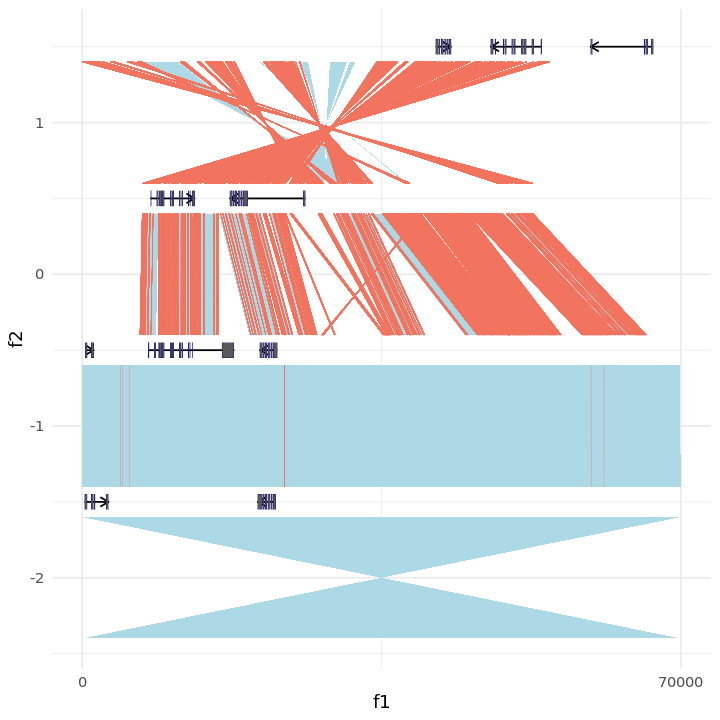

In [3]:
options(repr.plot.width = 6, repr.plot.height = 6)
library("ggplot2")

info <- read.table("test.info", header = T)

n = 1
block_len = 0.40
exon_h = 0.05


nn = 1.5
info
for (i in seq_len(nrow(info))){
    line <- info[i,]$Region
    #print (i)
    prefix <- info[i,]$Prefix
    gff <- info[i,]$GFF
    
    
    t <- strsplit(line,":")
    chro = t[[1]][1]
    start = strsplit(t[[1]][2],"-")[[1]][1]
    end = strsplit(t[[1]][2],"-")[[1]][2]
    fa <- paste0(prefix, "_", chro, "_", start, "_", end, ".fasta")
    cmd1 <- paste0("echo -e '", chro, "\t", start, "\t", end, "' | bedtools getfasta -bed - -fi ",
                 info[i,]$Genome, " -fo ", fa)
    #print (fa)
    #system(cmd1) ###########################################################################################################################################################
    
    cmd2 <- paste0("echo -e '", chro, "\t", start, "\t", end, "' | bedtools intersect -a - -b ",
                 gff, " -wo > ", paste0(prefix, ".gff3"))
    print (cmd2)
    system(cmd2)
    
    gf <- data.frame()
    if (file.info(paste0(prefix, ".gff3"))$size != 0){
        gf <- read.table(paste0(prefix, ".gff3"), header = F)
        gf$prefix <- prefix
        gf <- gf[(gf$V6=="gene")|(gf$V6=="exon"),]
        gf$exon_h1 <- nn - exon_h; gf$exon_h2 <- nn + exon_h; gf$gene_h <- nn
        
    }else{
        TRUE
    }
    #print (gf)
    
    nn = nn -1
    
    if (n == 1){
        l_fa <- fa; l_chro <- chro; l_start <- start; l_end <- end; l_pre <- prefix
        n = 0
        
        gfftotal <- gf
    } else if (n == 0){
        out <- data.frame(prefix1 = l_pre, prefix2 = prefix, fa1 = l_fa, fa2 = fa, chr1 = l_chro, chr2 = chro, start1 = l_start, start2 = start, end1 = l_end, end2 = end)
        l_fa <- fa; l_chro <- chro; l_start <- start; l_end <- end; l_pre <- prefix
        n = -1
        gfftotal <- rbind(gfftotal, gf)
    } else {
        out <- rbind(out, data.frame(prefix1 = l_pre, prefix2 = prefix, fa1 = l_fa, fa2 = fa, chr1 = l_chro, chr2 = chro, start1 = l_start, start2 = start, end1 = l_end, end2 = end))
        l_fa <- fa; l_chro <- chro; l_start <- start; l_end <- end; l_pre <- prefix
        gfftotal <- rbind(gfftotal, gf)
    }
    #print (end)
    #system2()
}

gfftotal$arrow <- ""
gfftotal[gfftotal$V10=="+",]$arrow <- "last"
gfftotal[gfftotal$V10=="-",]$arrow <- "first"
#out

#break

#block_len = 0.45

n = 1
nn = 1
for (i in seq_len(nrow(out))){
    l <- out[i,]
    prefix = paste0(l$prefix1, "_", l$prefix2)
    cmd <- paste0("dnadiff -p ",  prefix, " ", l$fa1, " ", l$fa2)
    
    #print (cmd)
    #system(cmd) ###################################################################################################################################################
    
    
    mcoords <- read.table(paste0(prefix, ".mcoords"), header = F)
    
    if (file.info(paste0(prefix, ".snps"))$size == 0){
        snps <- data.frame()
    }else{
        snps <- read.table(paste0(prefix, ".snps"), header = F)
    }
    
    
    
    if (n == 1){
        mcoords$prefix <- paste0(l$prefix1, l$prefix2)
        mcoords$n <- n
        mt <- mcoords
    }else{
        mcoords$prefix <- paste0(l$prefix1, l$prefix2)
        mcoords$n <- n
        mt <- rbind(mt, mcoords)
    }
    
    n = n - 1
    
    
    
    for (e in seq_len(nrow(mcoords))){
        s <- mcoords[e,]
        
        s1 <- data.frame(f1 = s$V1, f2 = s$n + block_len, f3 = nn, f4 = 1)
        s2 <- data.frame(f1 = s$V2, f2 = s$n + block_len, f3 = nn, f4 = 2)
        s3 <- data.frame(f1 = s$V4, f2 = s$n - block_len, f3 = nn, f4 = 3)
        s4 <- data.frame(f1 = s$V3, f2 = s$n - block_len, f3 = nn, f4 = 4)
        
        if (file.info(paste0(prefix, ".snps"))$size != 0){
            snps_t1 <- as.numeric(strsplit(strsplit(as.character(snps$V11[1]),":")[[1]][4],"-")[[1]][1])
            snps_t2 <- as.numeric(strsplit(strsplit(as.character(snps$V12[1]),":")[[1]][4],"-")[[1]][1])
            snps$st <- s$n + block_len
            snps$ed <- s$n - block_len
        }else{
            TRUE
        }
        
        if (nn == 1){
            sout <- rbind(s1,s2,s3,s4)
            if (file.info(paste0(prefix, ".snps"))$size != 0){
                snpst <- snps
            }else{
                TRUE
            }
        }else{
            sout <- rbind(sout, s1, s2, s3, s4)
            if (file.info(paste0(prefix, ".snps"))$size != 0){
                snpst <- rbind(snpst, snps)
            }else{
                TRUE
            }
        }
        
        nn = nn +1
        
    }
    
    #print (sout)
}

ggplot() + geom_polygon(sout, mapping=aes(x = f1 , y = f2 , group  = f3 ), linetype = 1, fill = "lightblue")+ 
      #geom_point(s, mapping = aes(x = V1, y = 5), color = "red", size = 0.2) + 
      #geom_point(s, mapping = aes(x = V4, y = 0), color = "red", size = 0.2) + 
      geom_segment(aes(x = V1, y = st, xend = V4, yend = ed), color = "#F2735E", size = .1 , data = snpst) + 
      geom_segment(data=gfftotal[gfftotal$V6=="gene",],
                   mapping = aes(x = V7-V2, y = (exon_h1 + exon_h2)/2, xend = V8-V2, yend=(exon_h1 + exon_h2)/2), 
                   arrow = arrow(length=unit(0.2, "cm"), ends = gfftotal[gfftotal$V6=="gene",]$arrow)) + 
      geom_rect(aes(xmin = V7-V2, ymin = exon_h1, xmax = V8-V2, ymax = exon_h2), colour = "navy", size = .1 , data = gfftotal[gfftotal$V6=="exon",]) +
      #geom_vline(xintercept = c(54542107-54540000,54605188-54540000)) +
      theme_minimal() + scale_x_continuous(limits =  c(0,max(max(snpst$V7),max(snpst$V8))), breaks = c(0,max(max(snpst$V7),max(snpst$V8))))# + ggtitle(prefix)


In [5]:
pdf("ROC22_Chr9F.synteny.pdf", height = 5, width = 7)
ggplot() + geom_polygon(sout, mapping=aes(x = f1 , y = f2 , group  = f3 ), linetype = 1, fill = "lightblue")+ 
      #geom_point(s, mapping = aes(x = V1, y = 5), color = "red", size = 0.2) + 
      #geom_point(s, mapping = aes(x = V4, y = 0), color = "red", size = 0.2) + 
      geom_segment(aes(x = V1, y = st, xend = V4, yend = ed), color = "#F2735E", size = .1 , data = snpst) + 
      geom_segment(data=gfftotal[gfftotal$V6=="gene",],
                   mapping = aes(x = V7-V2, y = (exon_h1 + exon_h2)/2, xend = V8-V2, yend=(exon_h1 + exon_h2)/2), 
                   arrow = arrow(length=unit(0.2, "cm"), ends = gfftotal[gfftotal$V6=="gene",]$arrow)) + 
      geom_rect(aes(xmin = V7-V2, ymin = exon_h1, xmax = V8-V2, ymax = exon_h2), colour = "navy", size = .1 , data = gfftotal[gfftotal$V6=="exon",]) +
      #geom_vline(xintercept = c(54542107-54540000,54605188-54540000)) +
      theme_minimal() + scale_x_continuous(limits =  c(0,max(max(snpst$V7),max(snpst$V8))), breaks = c(0,max(max(snpst$V7),max(snpst$V8))))# + ggtitle(prefix)
dev.off()

png 
  2

In [34]:
?geom_segment



geom_segment {ggplot2},R Documentation
mapping,"Set of aesthetic mappings created by aes() or aes_(). If specified and inherit.aes = TRUE (the default), it is combined with the default mapping at the top level of the plot. You must supply mapping if there is no plot mapping."
data,"The data to be displayed in this layer. There are three options: If NULL, the default, the data is inherited from the plot data as specified in the call to ggplot(). A data.frame, or other object, will override the plot data. All objects will be fortified to produce a data frame. See fortify() for which variables will be created. A function will be called with a single argument, the plot data. The return value must be a data.frame, and will be used as the layer data. A function can be created from a formula (e.g. ~ head(.x, 10))."
stat,"The statistical transformation to use on the data for this layer, as a string."
position,"Position adjustment, either as a string, or the result of a call to a position adjustment function."
...,"Other arguments passed on to layer(). These are often aesthetics, used to set an aesthetic to a fixed value, like colour = ""red"" or size = 3. They may also be parameters to the paired geom/stat."
arrow,"specification for arrow heads, as created by arrow()."
arrow.fill,fill colour to use for the arrow head (if closed). NULL means use colour aesthetic.
lineend,"Line end style (round, butt, square)."
linejoin,"Line join style (round, mitre, bevel)."
na.rm,"If FALSE, the default, missing values are removed with a warning. If TRUE, missing values are silently removed."


In [92]:
?read.table


read.table {utils},R Documentation
file,"the name of the file which the data are to be read from. Each row of the table appears as one line of the file. If it does not contain an absolute path, the file name is relative to the current working directory, getwd(). Tilde-expansion is performed where supported. This can be a compressed file (see file). Alternatively, file can be a readable text-mode connection (which will be opened for reading if necessary, and if so closed (and hence destroyed) at the end of the function call). (If stdin() is used, the prompts for lines may be somewhat confusing. Terminate input with a blank line or an EOF signal, Ctrl-D on Unix and Ctrl-Z on Windows. Any pushback on stdin() will be cleared before return.) file can also be a complete URL. (For the supported URL schemes, see the ‘URLs’ section of the help for url.)"
header,"a logical value indicating whether the file contains the names of the variables as its first line. If missing, the value is determined from the file format: header is set to TRUE if and only if the first row contains one fewer field than the number of columns."
sep,"the field separator character. Values on each line of the file are separated by this character. If sep = """" (the default for read.table) the separator is ‘white space’, that is one or more spaces, tabs, newlines or carriage returns."
quote,"the set of quoting characters. To disable quoting altogether, use quote = """". See scan for the behaviour on quotes embedded in quotes. Quoting is only considered for columns read as character, which is all of them unless colClasses is specified."
dec,the character used in the file for decimal points.
numerals,"string indicating how to convert numbers whose conversion to double precision would lose accuracy, see type.convert. Can be abbreviated. (Applies also to complex-number inputs.)"
row.names,"a vector of row names. This can be a vector giving the actual row names, or a single number giving the column of the table which contains the row names, or character string giving the name of the table column containing the row names. If there is a header and the first row contains one fewer field than the number of columns, the first column in the input is used for the row names. Otherwise if row.names is missing, the rows are numbered. Using row.names = NULL forces row numbering. Missing or NULL row.names generate row names that are considered to be ‘automatic’ (and not preserved by as.matrix)."
col.names,"a vector of optional names for the variables. The default is to use ""V"" followed by the column number."
as.is,"controls conversion of character variables (insofar as they are not converted to logical, numeric or complex) to factors, if not otherwise specified by colClasses. Its value is either a vector of logicals (values are recycled if necessary), or a vector of numeric or character indices which specify which columns should not be converted to factors. Note: to suppress all conversions including those of numeric columns, set colClasses = ""character"". Note that as.is is specified per column (not per variable) and so includes the column of row names (if any) and any columns to be skipped."
na.strings,"a character vector of strings which are to be interpreted as NA values. Blank fields are also considered to be missing values in logical, integer, numeric and complex fields. Note that the test happens after white space is stripped from the input, so na.strings values may need their own white space stripped in advance."
